In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy.linalg import inv
from numpy import random
import os

In [2]:
!apt-get install openjdk-11-jdk-headless -qq
!pip install pyspark==3.4.4
!pip install graphframes


Selecting previously unselected package openjdk-11-jre-headless:amd64.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../openjdk-11-jre-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Selecting previously unselected package openjdk-11-jdk-headless:amd64.
Preparing to unpack .../openjdk-11-jdk-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jdk-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/jav

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir(r"/content/drive/MyDrive/AML_Project")

**Start Spark Session**

Purpose: Initialize Spark so we can handle large transaction data.

In [6]:
from pyspark.sql import SparkSession
import os

# Explicitly set JAVA_HOME. This is a common fix for 'Java gateway process exited' in Colab.
# Verify the path to your Java installation. This is a typical path for openjdk-11 in Colab.
java_path = "/usr/lib/jvm/java-11-openjdk-amd64"
if os.path.exists(java_path):
    os.environ["JAVA_HOME"] = java_path
    print(f"JAVA_HOME set to: {os.environ['JAVA_HOME']}")
else:
    print(f"Warning: Java path not found at {java_path}. Please verify Java installation.")

spark = SparkSession.builder \
    .appName("AML-Graph") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.0-spark3.0-s_2.12") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark with GraphFrames started")

JAVA_HOME set to: /usr/lib/jvm/java-11-openjdk-amd64
Spark with GraphFrames started


**VERIFY GRAPHFRAMES WORKS**

In [7]:
from graphframes import GraphFrame

print("GraphFrames imported successfully")


GraphFrames imported successfully


**Load HI-Small Transaction File**



In [8]:
from pyspark.sql.functions import col

trans = spark.read.csv(
"/content/drive/MyDrive/AML_Project/HI-Small_Trans.csv",
header=True,
    inferSchema=True
)


In [9]:
trans.show(5)

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:20|       10|8000EBD30|     10|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:20|     3208|8000F4580|      1|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|
|2022/09/01 00:00|     3209|8000F4670|   3209|8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:02|       12|8000F5030|     12|8000F5030|        2806.97|         US Dollar|    2806.

In [10]:
trans.printSchema()


root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: double (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)



In [11]:
print(f"Number of rows in 'trans' DataFrame: {trans.count()}")
print("\nDistinct values and their counts for 'Payment Format' (interpreted as transaction code):")
trans.groupBy("Payment Format").count().show()

Number of rows in 'trans' DataFrame: 5078345

Distinct values and their counts for 'Payment Format' (interpreted as transaction code):
+--------------+-------+
|Payment Format|  count|
+--------------+-------+
|       Bitcoin| 146091|
|  Reinvestment| 481056|
|   Credit Card|1323324|
|           ACH| 600797|
|        Cheque|1864331|
|          Cash| 490891|
|          Wire| 171855|
+--------------+-------+



**Clean and Rename Columns**

We now standardize column names for graph processing

In [12]:
from pyspark.sql.functions import col

transactions = trans.select(
    col("Account2").alias("src"),
    col("Account4").alias("dst"),
    col("Amount Paid").alias("amount"),
    col("Timestamp").alias("timestamp")
)

In [13]:
transactions.show(5)


+---------+---------+--------+----------------+
|      src|      dst|  amount|       timestamp|
+---------+---------+--------+----------------+
|8000EBD30|8000EBD30| 3697.34|2022/09/01 00:20|
|8000F4580|8000F5340|    0.01|2022/09/01 00:20|
|8000F4670|8000F4670|14675.57|2022/09/01 00:00|
|8000F5030|8000F5030| 2806.97|2022/09/01 00:02|
|8000F5200|8000F5200|36682.97|2022/09/01 00:06|
+---------+---------+--------+----------------+
only showing top 5 rows



**STEP 2 — BUILDING THE TRANSACTION GRAPH (CORE LOGIC)**

This step converts raw transaction rows into a graph structure, which is the foundation for detecting money laundering patterns.

**Create Nodes (Vertices)**


Each bank account becomes a node in the graph.

In [14]:
from pyspark.sql.functions import col

# Extract all unique accounts from sender and receiver
vertices = (
    transactions.select(col("src").alias("id"))
    .union(transactions.select(col("dst").alias("id")))
    .distinct()
)

vertices.show(5)


+---------+
|       id|
+---------+
|8000F5200|
|8000F5AD0|
|8005F2D30|
|8005FB700|
|8006A3840|
+---------+
only showing top 5 rows



**Create Edges (Money Transfers)**

Edges represent flow of money between accounts.

In [15]:
edges = transactions.select(
    col("src"),
    col("dst"),
    col("amount"),
    col("timestamp")
)


**Build the GraphFrame**

Now we combine vertices + edges.

In [16]:
from graphframes import GraphFrame

graph = GraphFrame(vertices, edges)


**Validate the Graph**

Always check before moving forward.

In [17]:

graph.vertices.show(5)
graph.edges.show(5)


+---------+
|       id|
+---------+
|8000F5200|
|8000F5AD0|
|8005F2D30|
|8005FB700|
|8006A3840|
+---------+
only showing top 5 rows

+---------+---------+--------+----------------+
|      src|      dst|  amount|       timestamp|
+---------+---------+--------+----------------+
|8000EBD30|8000EBD30| 3697.34|2022/09/01 00:20|
|8000F4580|8000F5340|    0.01|2022/09/01 00:20|
|8000F4670|8000F4670|14675.57|2022/09/01 00:00|
|8000F5030|8000F5030| 2806.97|2022/09/01 00:02|
|8000F5200|8000F5200|36682.97|2022/09/01 00:06|
+---------+---------+--------+----------------+
only showing top 5 rows



**STEP 3 — DETECT SUSPICIOUS TRANSACTION PATTERNS (MOTIFS)**

We will detect three classic money laundering behaviors:

1. Fan-Out – One account sending money to many accounts
2. Fan-In – Many accounts sending money to one account
3. Circular Transactions – Money moving in loops

**FAN-OUT DETECTION (Sender → Many Receivers)**
Meaning:

One account distributing money to many others (possible layering or mule network).

In [18]:
fan_out = graph.outDegrees.orderBy("outDegree", ascending=False)
fan_out.show(10)


+---------+---------+
|       id|outDegree|
+---------+---------+
|100428660|   168672|
|1004286A8|   103018|
|100428978|    20497|
|1004286F0|    18663|
|100428780|    17264|
|1004289C0|    16794|
|100428810|    16426|
|1004287C8|    14174|
|100428738|    13756|
|100428A51|    13073|
+---------+---------+
only showing top 10 rows



**FAN-IN DETECTION (Many → One)**

Meaning:

Multiple accounts sending money to one account (aggregation point).

In [19]:
fan_in = graph.inDegrees.orderBy("inDegree", ascending=False)
fan_in.show(10)


+---------+--------+
|       id|inDegree|
+---------+--------+
|100428660|    1084|
|1004286A8|     653|
|80F47A310|     159|
|100428978|     150|
|8018859B0|     144|
|1004289C0|     132|
|100428780|     117|
|100428810|     114|
|80F0EF460|     109|
|1004286F0|     108|
+---------+--------+
only showing top 10 rows



**CIRCULAR TRANSACTIONS (Layering)**

Meaning:

Money flows in loops to hide origin.

In [20]:
cycles = graph.find("(a)-[e1]->(b); (b)-[e2]->(a)")
cycles.show(10)


+-----------+--------------------+-----------+--------------------+
|          a|                  e1|          b|                  e2|
+-----------+--------------------+-----------+--------------------+
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
|{800044A00}|{800044A00, 80004...|{800044A00}|{800044A00, 80004...|
+-----------+--------------------+-----------+--------------------+
only showing top 10 rows



**STEP 4 — RISK SCORING (CORE INTELLIGENCE LAYER)**

Combine Graph Metrics

We already computed:

fan_out (outDegree)

fan_in (inDegree)

Now we combine them into a single risk table.

In [21]:
from pyspark.sql.functions import col, when


In [22]:
# Join fan-in and fan-out scores
risk_df = fan_out.join(
    fan_in,
    on="id",
    how="outer"
).fillna(0)


**Create a Risk Score Formula**

In [23]:
risk_df = risk_df.withColumn(
    "risk_score",
    (col("outDegree") * 0.6) + (col("inDegree") * 0.4)
)


** Rank Accounts by Risk**

In [24]:
risk_df = risk_df.orderBy(col("risk_score").desc())
risk_df.show(10)


+---------+---------+--------+------------------+
|       id|outDegree|inDegree|        risk_score|
+---------+---------+--------+------------------+
|100428660|   168672|    1084|          101636.8|
|1004286A8|   103018|     653| 62071.99999999999|
|100428978|    20497|     150|12358.199999999999|
|1004286F0|    18663|     108|           11241.0|
|100428780|    17264|     117|10405.199999999999|
|1004289C0|    16794|     132|10129.199999999999|
|100428810|    16426|     114|            9901.2|
|1004287C8|    14174|     103|            8545.6|
|100428738|    13756|      98| 8292.800000000001|
|100428A51|    13073|      28| 7854.999999999999|
+---------+---------+--------+------------------+
only showing top 10 rows



**OPTIONAL: Add Risk Label**

To make results more interpretable:

In [25]:
risk_df = risk_df.withColumn(
    "risk_label",
    when(col("risk_score") >= 10, "HIGH")
    .when(col("risk_score") >= 5, "MEDIUM")
    .otherwise("LOW")
)


**STEP 4.1 — Verify Risk Scores Before Moving Ahead**

Display Top Risky Accounts

In [26]:
risk_df.show(10)


+---------+---------+--------+------------------+----------+
|       id|outDegree|inDegree|        risk_score|risk_label|
+---------+---------+--------+------------------+----------+
|100428660|   168672|    1084|          101636.8|      HIGH|
|1004286A8|   103018|     653| 62071.99999999999|      HIGH|
|100428978|    20497|     150|12358.199999999999|      HIGH|
|1004286F0|    18663|     108|           11241.0|      HIGH|
|100428780|    17264|     117|10405.199999999999|      HIGH|
|1004289C0|    16794|     132|10129.199999999999|      HIGH|
|100428810|    16426|     114|            9901.2|      HIGH|
|1004287C8|    14174|     103|            8545.6|      HIGH|
|100428738|    13756|      98| 8292.800000000001|      HIGH|
|100428A51|    13073|      28| 7854.999999999999|      HIGH|
+---------+---------+--------+------------------+----------+
only showing top 10 rows



**Check Distribution (Sanity Check)**

We want to see if only few accounts are risky (which is realistic).

In [27]:
risk_df.select("risk_score").describe().show()


+-------+------------------+
|summary|        risk_score|
+-------+------------------+
|  count|            515080|
|   mean| 9.859332530871262|
| stddev|171.99636112558056|
|    min|               0.4|
|    max|          101636.8|
+-------+------------------+



**STEP 4.2 — LABEL HIGH-RISK ACCOUNTS (THRESHOLDING)**

**Apply Risk Labels in Spark**

In [28]:
from pyspark.sql.functions import when

risk_labeled = risk_df.withColumn(
    "risk_label",
    when(col("risk_score") >= 8, "HIGH")
    .when(col("risk_score") >= 4, "MEDIUM")
    .otherwise("LOW")
)


View Final Risk Table

In [29]:
risk_labeled.orderBy(col("risk_score").desc()).show(10)


+---------+---------+--------+------------------+----------+
|       id|outDegree|inDegree|        risk_score|risk_label|
+---------+---------+--------+------------------+----------+
|100428660|   168672|    1084|          101636.8|      HIGH|
|1004286A8|   103018|     653| 62071.99999999999|      HIGH|
|100428978|    20497|     150|12358.199999999999|      HIGH|
|1004286F0|    18663|     108|           11241.0|      HIGH|
|100428780|    17264|     117|10405.199999999999|      HIGH|
|1004289C0|    16794|     132|10129.199999999999|      HIGH|
|100428810|    16426|     114|            9901.2|      HIGH|
|1004287C8|    14174|     103|            8545.6|      HIGH|
|100428738|    13756|      98| 8292.800000000001|      HIGH|
|100428A51|    13073|      28| 7854.999999999999|      HIGH|
+---------+---------+--------+------------------+----------+
only showing top 10 rows



**STEP 5 — VISUALIZE HIGH-RISK ACCOUNTS IN THE TRANSACTION GRAPH**

Convert Spark Graph to NetworkX

In [30]:
import networkx as nx
import matplotlib.pyplot as plt


Convert edges to pandas first:

In [31]:
edges_pd = graph.edges.select("src", "dst").toPandas()


Create NetworkX graph:

In [32]:
G = nx.from_pandas_edgelist(edges_pd, source="src", target="dst", create_using=nx.DiGraph())


STEP 5.2 — Attach Risk Scores to Nodes

We need to color nodes by risk level.

In [33]:
risk_pd = risk_labeled.select("id", "risk_label").toPandas()

risk_map = dict(zip(risk_pd["id"], risk_pd["risk_label"]))


Assign colors:

In [34]:
node_colors = []
for node in G.nodes():
    if node in risk_map:
        if risk_map[node] == "HIGH":
            node_colors.append("red")
        elif risk_map[node] == "MEDIUM":
            node_colors.append("orange")
        else:
            node_colors.append("green")
    else:
        node_colors.append("gray")


**FILTER ONLY HIGH-RISK ACCOUNTS**

In [35]:
# Get top risky nodes
high_risk_nodes = risk_labeled \
    .filter(col("risk_label") == "HIGH") \
    .select("id") \
    .limit(10) \
    .rdd.flatMap(lambda x: x) \
    .collect()


Create Subgraph (Safe & Fast)

In [36]:
sub_edges = edges_pd[
    (edges_pd["src"].isin(high_risk_nodes)) |
    (edges_pd["dst"].isin(high_risk_nodes))
]

G_sub = nx.from_pandas_edgelist(
    sub_edges,
    source="src",
    target="dst",
    create_using=nx.DiGraph()
)


In [37]:
print("Number of nodes:", G_sub.number_of_nodes())
print("Number of edges:", G_sub.number_of_edges())


Number of nodes: 35458
Number of edges: 35449


**SAFE VISUALIZATION (TOP-N NODES ONLY)**

In [38]:
# Take top 20 nodes only
top_nodes = list(G_sub.nodes())[:20]
G_small = G_sub.subgraph(top_nodes)


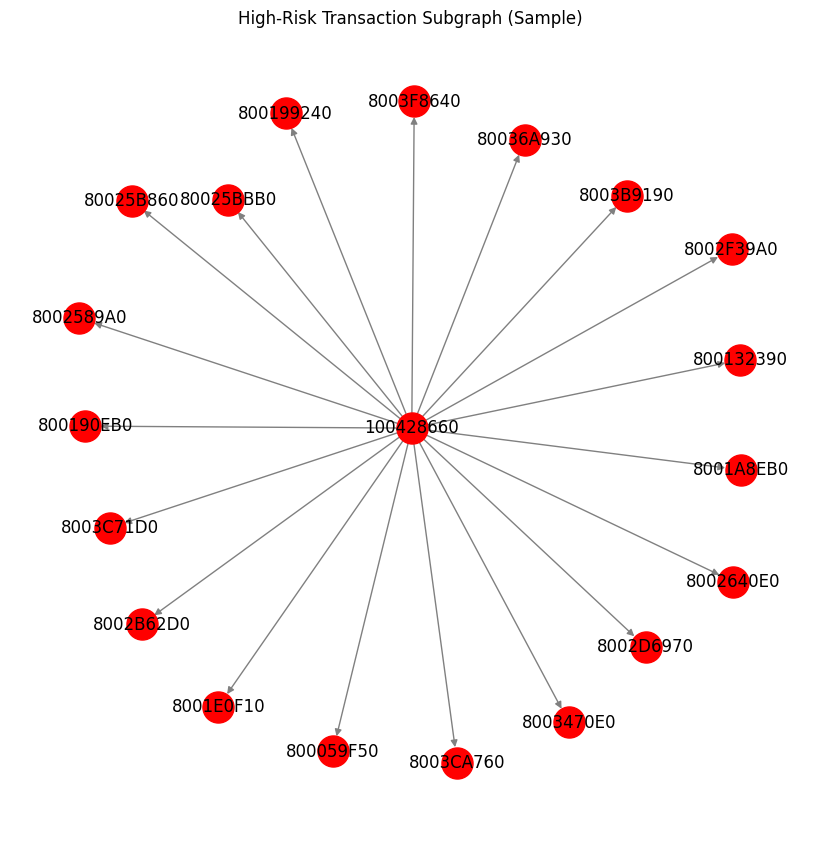

In [39]:
plt.figure(figsize=(8, 8))

pos = nx.spring_layout(G_small, seed=42, k=0.5)

nx.draw(
    G_small,
    pos,
    with_labels=True,
    node_color="red",
    node_size=500,
    edge_color="gray"
)

plt.title("High-Risk Transaction Subgraph (Sample)")
plt.show()


### STEP 6 — INTRODUCTION TO GNN (Graph Neural Network)

STEP 6.1 — PREPARE GRAPH FOR GNN

STEP 6.1.1 — Convert Spark Graph → Pandas

In [40]:
# Convert edges to pandas
edges_pd = edges.select("src", "dst").toPandas()


STEP 6.1.2 — Create Node Index Mapping

In [41]:
import pandas as pd

nodes = pd.unique(edges_pd[['src', 'dst']].values.ravel())
node_map = {node: i for i, node in enumerate(nodes)}


STEP 6.1.3 — Build Edge Index Tensor

In [42]:
import torch

edge_index = torch.tensor([
    [node_map[src] for src in edges_pd['src']],
    [node_map[dst] for dst in edges_pd['dst']]
], dtype=torch.long)


STEP 6.1.4 — Create Node Features

For now, we use simple features:

Degree-based features (safe + effective)

In [43]:
import numpy as np

num_nodes = len(node_map)
x = torch.zeros((num_nodes, 1))  # simple 1D feature

# Optional: degree-based feature
for src, dst in zip(edges_pd['src'], edges_pd['dst']):
    x[node_map[src]] += 1
    x[node_map[dst]] += 1


STEP 6.1.5 — Build PyG Data Object

In [44]:
!pip install torch_geometric
from torch_geometric.data import Data

data = Data(
    x=x,
    edge_index=edge_index
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00


**STEP 7 — TRAIN A GRAPH NEURAL NETWORK (GNN**

STEP 7.1 — Define the GNN Model

We’ll use a simple GCN (Graph Convolutional Network) — perfect for learning structural patterns.

In [45]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [46]:
class AML_GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)


STEP 7.2 — Prepare Training Targets

Since we don’t have real labels, we use weak supervision.

In [47]:
# create labels based on previous risk scoring
labels = torch.zeros((data.num_nodes, 1))

for i, node in enumerate(node_map):
    if node in high_risk_nodes:
        labels[i] = 1


STEP 7.3 — Train the Model

In [48]:
model = AML_GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    out = model(data)
    loss = F.binary_cross_entropy(out, labels)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.2916
Epoch 10, Loss: 0.0614
Epoch 20, Loss: 0.0230
Epoch 30, Loss: 0.0126
Epoch 40, Loss: 0.0087


STEP 7.4 — Interpret Model Output

In [49]:
with torch.no_grad():
    predictions = model(data).squeeze()


In [50]:
top_risky = torch.argsort(predictions, descending=True)[:10]
top_risky


tensor([387306, 242040, 242038, 423784, 423790, 423791, 341427,  16156, 423805,
        341438])

## STEP 8 — AUTOMATED SAR (Suspicious Activity Report) GENERATION

STEP 8.1 — Select High-Risk Accounts

We define a threshold (example: top 5%).

In [51]:
import numpy as np

# Convert risk_labeled Spark DataFrame to Pandas DataFrame for numpy.percentile
# Or, if you want to keep it in Spark, you'd use Spark SQL functions for percentile.
# For consistency with the numpy percentile usage, let's convert to pandas for this step.
risk_labeled_pd = risk_labeled.select("risk_score").toPandas()

threshold = np.percentile(risk_labeled_pd["risk_score"], 95)
high_risk_accounts_spark = risk_labeled.filter(risk_labeled["risk_score"] >= threshold)

high_risk_accounts_spark.show(5)

+---------+---------+--------+------------------+----------+
|       id|outDegree|inDegree|        risk_score|risk_label|
+---------+---------+--------+------------------+----------+
|100428660|   168672|    1084|          101636.8|      HIGH|
|1004286A8|   103018|     653| 62071.99999999999|      HIGH|
|100428978|    20497|     150|12358.199999999999|      HIGH|
|1004286F0|    18663|     108|           11241.0|      HIGH|
|100428780|    17264|     117|10405.199999999999|      HIGH|
+---------+---------+--------+------------------+----------+
only showing top 5 rows



STEP 8.2 — Create Natural Language Evidence

We create structured text describing suspicious behavior.

In [52]:
reports = []

# Convert the Spark DataFrame to a Pandas DataFrame for iteration
high_risk_accounts_pd = high_risk_accounts_spark.toPandas()

for _, row in high_risk_accounts_pd.iterrows():
    report = f"""
    Account {row['id']} has been flagged as HIGH RISK (Risk Score: {row['risk_score']:.2f}).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: {row['outDegree']}, In-Degree: {row['inDegree']}).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    """
    reports.append(report)

print(f"Generated {len(reports)} SARs for high-risk accounts.")
for i, sar in enumerate(reports[:5]): # Print first 5 reports as an example
    print(f"--- SAR {i+1} ---")
    print(sar)
    print("-------------------")

Generated 25937 SARs for high-risk accounts.
--- SAR 1 ---

    Account 100428660 has been flagged as HIGH RISK (Risk Score: 101636.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168672, In-Degree: 1084).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
-------------------
--- SAR 2 ---

    Account 1004286A8 has been flagged as HIGH RISK (Risk Score: 62072.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 103018, In-Degree: 653).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
-------------------
--- SAR 3 ---

    Account 100428978 has been flagged as HIGH RISK (Risk Score: 12358.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 20497, In-Degree: 150).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
-----------

STEP 8.3 — Generate SAR Using LLM (Local or Cloud)

If using LangChain + LLM:

In [ ]:
from transformers import pipeline

# Install langchain if not already installed
!pip install langchain==0.1.20 langchain-community==0.0.38
from langchain.llms import HuggingFacePipeline

generator = pipeline("text-generation", model="google/flan-t5-base")

for r in reports:
    prompt = f"Generate a professional Suspicious Activity Report:\n{r}"
    print(generator(prompt, max_length=200)[0]["generated_text"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.1/303.1 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: numpy
    Found existing

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOl

Generate a professional Suspicious Activity Report:

    Account 100428660 has been flagged as HIGH RISK (Risk Score: 101636.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168672, In-Degree: 1084).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 1004286A8 has been flagged as HIGH RISK (Risk Score: 62072.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 103018, In-Degree: 653).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428978 has been flagged as HIGH RISK (Risk Score: 12358.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 20497, In-Degree: 150).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 1004286F0 has been flagged as HIGH RISK (Risk Score: 11241.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 18663, In-Degree: 108).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428780 has been flagged as HIGH RISK (Risk Score: 10405.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 17264, In-Degree: 117).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 1004289C0 has been flagged as HIGH RISK (Risk Score: 10129.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 16794, In-Degree: 132).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428810 has been flagged as HIGH RISK (Risk Score: 9901.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 16426, In-Degree: 114).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 1004287C8 has been flagged as HIGH RISK (Risk Score: 8545.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 14174, In-Degree: 103).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428738 has been flagged as HIGH RISK (Risk Score: 8292.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 13756, In-Degree: 98).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428A51 has been flagged as HIGH RISK (Risk Score: 7855.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 13073, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 1004288A0 has been flagged as HIGH RISK (Risk Score: 7434.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 12330, In-Degree: 90).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428858 has been flagged as HIGH RISK (Risk Score: 6633.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 11000, In-Degree: 83).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 1004288E8 has been flagged as HIGH RISK (Risk Score: 5701.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 9471, In-Degree: 48).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428A08 has been flagged as HIGH RISK (Risk Score: 4992.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 8290, In-Degree: 47).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 100428930 has been flagged as HIGH RISK (Risk Score: 3873.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 6431, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800058B80 has been flagged as HIGH RISK (Risk Score: 227.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 351, In-Degree: 43).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80006FCE0 has been flagged as HIGH RISK (Risk Score: 213.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 296, In-Degree: 90).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800058920 has been flagged as HIGH RISK (Risk Score: 188.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 279, In-Degree: 52).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005ADE0 has been flagged as HIGH RISK (Risk Score: 176.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 276, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C5D00 has been flagged as HIGH RISK (Risk Score: 175.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 273, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000B8AB0 has been flagged as HIGH RISK (Risk Score: 175.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 253, In-Degree: 59).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000F7C60 has been flagged as HIGH RISK (Risk Score: 174.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 263, In-Degree: 41).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8015EEE90 has been flagged as HIGH RISK (Risk Score: 167.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 222, In-Degree: 86).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 803037BE0 has been flagged as HIGH RISK (Risk Score: 167.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 258, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800105F00 has been flagged as HIGH RISK (Risk Score: 167.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 274, In-Degree: 8).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001B1C30 has been flagged as HIGH RISK (Risk Score: 167.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 268, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    58,378.40). The accounts of 8001B1C30 were reported as high risk due to abnormal connectivity patterns.


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001C8580 has been flagged as HIGH RISK (Risk Score: 164.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 244, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800058470 has been flagged as HIGH RISK (Risk Score: 163.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 254, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800167090 has been flagged as HIGH RISK (Risk Score: 163.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 271, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (800167090): (80016090):


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80018AE80 has been flagged as HIGH RISK (Risk Score: 162.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 255, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004203B0 has been flagged as HIGH RISK (Risk Score: 161.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 239, In-Degree: 46).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80042F4A0 has been flagged as HIGH RISK (Risk Score: 161.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 212, In-Degree: 86).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80006AC70 has been flagged as HIGH RISK (Risk Score: 160.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 225, In-Degree: 63).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80FD2DBC0 has been flagged as HIGH RISK (Risk Score: 159.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 265, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800102DD0 has been flagged as HIGH RISK (Risk Score: 158.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 263, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8007E86B0 has been flagged as HIGH RISK (Risk Score: 157.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 201, In-Degree: 93).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005A2A0 has been flagged as HIGH RISK (Risk Score: 156.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 231, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80023D380 has been flagged as HIGH RISK (Risk Score: 156.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 237, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800089960 has been flagged as HIGH RISK (Risk Score: 156.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 245, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800788330 has been flagged as HIGH RISK (Risk Score: 154.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 216, In-Degree: 62).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800061BD0 has been flagged as HIGH RISK (Risk Score: 154.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 251, In-Degree: 9).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C2170 has been flagged as HIGH RISK (Risk Score: 153.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 224, In-Degree: 48).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80010F6E0 has been flagged as HIGH RISK (Risk Score: 153.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 241, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8007C51F0 has been flagged as HIGH RISK (Risk Score: 152.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 253, In-Degree: 2).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000611E0 has been flagged as HIGH RISK (Risk Score: 152.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 238, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800057020 has been flagged as HIGH RISK (Risk Score: 152.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 210, In-Degree: 65).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800098200 has been flagged as HIGH RISK (Risk Score: 151.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 237, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800055DF0 has been flagged as HIGH RISK (Risk Score: 150.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 245, In-Degree: 9).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8005E5290 has been flagged as HIGH RISK (Risk Score: 150.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 239, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005FB10 has been flagged as HIGH RISK (Risk Score: 150.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 234, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001580D0 has been flagged as HIGH RISK (Risk Score: 150.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 232, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000631E0 has been flagged as HIGH RISK (Risk Score: 149.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 238, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8001B73A0 has been flagged as HIGH RISK (Risk Score: 149.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 234, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800142A60 has been flagged as HIGH RISK (Risk Score: 149.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 235, In-Degree: 21).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80004B890 has been flagged as HIGH RISK (Risk Score: 149.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 227, In-Degree: 33).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800063CE0 has been flagged as HIGH RISK (Risk Score: 149.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 232, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8007F7190 has been flagged as HIGH RISK (Risk Score: 149.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 230, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8002045A0 has been flagged as HIGH RISK (Risk Score: 149.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 223, In-Degree: 38).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000CDD30 has been flagged as HIGH RISK (Risk Score: 148.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 224, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005E100 has been flagged as HIGH RISK (Risk Score: 148.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 232, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800426970 has been flagged as HIGH RISK (Risk Score: 148.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 215, In-Degree: 49).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8005E4980 has been flagged as HIGH RISK (Risk Score: 148.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 230, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 807661E30 has been flagged as HIGH RISK (Risk Score: 148.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 237, In-Degree: 15).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000621D0 has been flagged as HIGH RISK (Risk Score: 147.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 216, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000F89F0 has been flagged as HIGH RISK (Risk Score: 147.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 245, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800785CB0 has been flagged as HIGH RISK (Risk Score: 147.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 231, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80011AE70 has been flagged as HIGH RISK (Risk Score: 146.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 209, In-Degree: 52).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800062960 has been flagged as HIGH RISK (Risk Score: 145.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 241, In-Degree: 2).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000677F0 has been flagged as HIGH RISK (Risk Score: 145.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 225, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 802212040 has been flagged as HIGH RISK (Risk Score: 145.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 216, In-Degree: 39).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80041D720 has been flagged as HIGH RISK (Risk Score: 144.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 229, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800054E60 has been flagged as HIGH RISK (Risk Score: 144.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 222, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8002BAB10 has been flagged as HIGH RISK (Risk Score: 143.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 225, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005F430 has been flagged as HIGH RISK (Risk Score: 143.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 222, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80140BA90 has been flagged as HIGH RISK (Risk Score: 143.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 83).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80010E5E0 has been flagged as HIGH RISK (Risk Score: 143.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 215, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    K by the U.S. Securities and Exchange Commission. The model detects abnormal connectivity patterns indicating potential money laundering.


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80E17AD60 has been flagged as HIGH RISK (Risk Score: 143.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 227, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800090BA0 has been flagged as HIGH RISK (Risk Score: 143.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 209, In-Degree: 44).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000942D0 has been flagged as HIGH RISK (Risk Score: 142.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 200, In-Degree: 57).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800135370 has been flagged as HIGH RISK (Risk Score: 142.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 222, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80024E7A0 has been flagged as HIGH RISK (Risk Score: 142.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 225, In-Degree: 19).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800100AD0 has been flagged as HIGH RISK (Risk Score: 142.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 224, In-Degree: 20).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8005F4520 has been flagged as HIGH RISK (Risk Score: 142.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 199, In-Degree: 57).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000573C0 has been flagged as HIGH RISK (Risk Score: 141.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 219, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800117BE0 has been flagged as HIGH RISK (Risk Score: 140.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 208, In-Degree: 40).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8002B5EE0 has been flagged as HIGH RISK (Risk Score: 140.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 202, In-Degree: 48).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8008EE530 has been flagged as HIGH RISK (Risk Score: 140.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 204, In-Degree: 44).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8033EC600 has been flagged as HIGH RISK (Risk Score: 140.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 162, In-Degree: 107).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001BB380 has been flagged as HIGH RISK (Risk Score: 139.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 209, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8001F0820 has been flagged as HIGH RISK (Risk Score: 139.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 196, In-Degree: 55).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800094C70 has been flagged as HIGH RISK (Risk Score: 139.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 209, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800188040 has been flagged as HIGH RISK (Risk Score: 139.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 209, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 802485240 has been flagged as HIGH RISK (Risk Score: 139.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 78).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001B0770 has been flagged as HIGH RISK (Risk Score: 139.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 207, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800070AD0 has been flagged as HIGH RISK (Risk Score: 138.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 212, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005B9B0 has been flagged as HIGH RISK (Risk Score: 138.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 189, In-Degree: 62).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80054C140 has been flagged as HIGH RISK (Risk Score: 138.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 210, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800259050 has been flagged as HIGH RISK (Risk Score: 138.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 206, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    se be aware that certain countries may consider their countries insecure on Internet security standards.


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800354AF0 has been flagged as HIGH RISK (Risk Score: 138.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 200, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001CB7C0 has been flagged as HIGH RISK (Risk Score: 137.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 224, In-Degree: 8).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000D09B0 has been flagged as HIGH RISK (Risk Score: 137.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 69).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800910CC0 has been flagged as HIGH RISK (Risk Score: 137.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 203, In-Degree: 39).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80769AD90 has been flagged as HIGH RISK (Risk Score: 137.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 193, In-Degree: 54).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800043210 has been flagged as HIGH RISK (Risk Score: 137.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 209, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000F7850 has been flagged as HIGH RISK (Risk Score: 137.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 212, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000674A0 has been flagged as HIGH RISK (Risk Score: 137.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 217, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000B11C0 has been flagged as HIGH RISK (Risk Score: 136.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 204, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800829FA0 has been flagged as HIGH RISK (Risk Score: 136.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 192, In-Degree: 54).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004661C0 has been flagged as HIGH RISK (Risk Score: 135.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 225, In-Degree: 2).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8009D3520 has been flagged as HIGH RISK (Risk Score: 135.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 63).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80009B470 has been flagged as HIGH RISK (Risk Score: 135.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 193, In-Degree: 49).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003278E0 has been flagged as HIGH RISK (Risk Score: 135.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 215, In-Degree: 16).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800077C70 has been flagged as HIGH RISK (Risk Score: 135.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 201, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800128AC0 has been flagged as HIGH RISK (Risk Score: 135.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 218, In-Degree: 11).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800349840 has been flagged as HIGH RISK (Risk Score: 135.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 208, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800465CF0 has been flagged as HIGH RISK (Risk Score: 135.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 195, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80006B030 has been flagged as HIGH RISK (Risk Score: 134.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 198, In-Degree: 40).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000A2A00 has been flagged as HIGH RISK (Risk Score: 134.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 212, In-Degree: 19).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005C790 has been flagged as HIGH RISK (Risk Score: 134.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 211, In-Degree: 20).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001E23A0 has been flagged as HIGH RISK (Risk Score: 134.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 199, In-Degree: 38).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004F0FB0 has been flagged as HIGH RISK (Risk Score: 134.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 207, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8047AF8D0 has been flagged as HIGH RISK (Risk Score: 134.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 205, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 801E759B0 has been flagged as HIGH RISK (Risk Score: 134.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 174, In-Degree: 75).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8012DDCE0 has been flagged as HIGH RISK (Risk Score: 134.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 174, In-Degree: 75).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80110E450 has been flagged as HIGH RISK (Risk Score: 134.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 65).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8012A6610 has been flagged as HIGH RISK (Risk Score: 134.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 198, In-Degree: 38).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800150F20 has been flagged as HIGH RISK (Risk Score: 133.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 195, In-Degree: 42).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C43D0 has been flagged as HIGH RISK (Risk Score: 133.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 200, In-Degree: 34).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80058A750 has been flagged as HIGH RISK (Risk Score: 133.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 204, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001A37B0 has been flagged as HIGH RISK (Risk Score: 133.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 191, In-Degree: 46).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004981D0 has been flagged as HIGH RISK (Risk Score: 133.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 191, In-Degree: 46).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80CCB4820 has been flagged as HIGH RISK (Risk Score: 132.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 200, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8039DA9B0 has been flagged as HIGH RISK (Risk Score: 132.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 192, In-Degree: 44).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000F42A0 has been flagged as HIGH RISK (Risk Score: 132.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 205, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800D36B20 has been flagged as HIGH RISK (Risk Score: 132.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 56).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8010B59E0 has been flagged as HIGH RISK (Risk Score: 132.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 160, In-Degree: 90).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8006757B0 has been flagged as HIGH RISK (Risk Score: 131.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 193, In-Degree: 40).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800D70880 has been flagged as HIGH RISK (Risk Score: 131.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 47).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 811A4A580 has been flagged as HIGH RISK (Risk Score: 131.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 206, In-Degree: 19).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8005E0F80 has been flagged as HIGH RISK (Risk Score: 131.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 199, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80012A760 has been flagged as HIGH RISK (Risk Score: 130.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 206, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800250820 has been flagged as HIGH RISK (Risk Score: 130.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 195, In-Degree: 33).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800063990 has been flagged as HIGH RISK (Risk Score: 130.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 204, In-Degree: 19).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001D8CB0 has been flagged as HIGH RISK (Risk Score: 130.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 202, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800060420 has been flagged as HIGH RISK (Risk Score: 129.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 205, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001547E0 has been flagged as HIGH RISK (Risk Score: 129.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 196, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001F6960 has been flagged as HIGH RISK (Risk Score: 129.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 191, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800B18660 has been flagged as HIGH RISK (Risk Score: 129.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 67).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    e following risk scores: Out-Degree: 171, In-Degree: 67


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001E37F0 has been flagged as HIGH RISK (Risk Score: 129.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 43).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8000776E0 has been flagged as HIGH RISK (Risk Score: 129.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 200, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80DB92B20 has been flagged as HIGH RISK (Risk Score: 128.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 204, In-Degree: 16).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80005E380 has been flagged as HIGH RISK (Risk Score: 128.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 56).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80037B460 has been flagged as HIGH RISK (Risk Score: 128.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 203, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80038A310 has been flagged as HIGH RISK (Risk Score: 128.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 197, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8006EC4E0 has been flagged as HIGH RISK (Risk Score: 128.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 195, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001A8960 has been flagged as HIGH RISK (Risk Score: 128.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 193, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80087CBA0 has been flagged as HIGH RISK (Risk Score: 128.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 191, In-Degree: 34).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003D3C10 has been flagged as HIGH RISK (Risk Score: 128.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 40).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800260000 has been flagged as HIGH RISK (Risk Score: 128.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 164, In-Degree: 74).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000466F0 has been flagged as HIGH RISK (Risk Score: 127.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 201, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 806106DB0 has been flagged as HIGH RISK (Risk Score: 127.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 195, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800069740 has been flagged as HIGH RISK (Risk Score: 127.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800266160 has been flagged as HIGH RISK (Risk Score: 127.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 64).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800542F90 has been flagged as HIGH RISK (Risk Score: 127.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 196, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 806101600 has been flagged as HIGH RISK (Risk Score: 127.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 808AF0AF0 has been flagged as HIGH RISK (Risk Score: 127.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 164, In-Degree: 73).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8007B5E20 has been flagged as HIGH RISK (Risk Score: 127.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80004CA20 has been flagged as HIGH RISK (Risk Score: 126.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 47).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 802E98AD0 has been flagged as HIGH RISK (Risk Score: 126.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 160, In-Degree: 77).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001693A0 has been flagged as HIGH RISK (Risk Score: 126.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 42).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001BD460 has been flagged as HIGH RISK (Risk Score: 126.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 181, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80008DDF0 has been flagged as HIGH RISK (Risk Score: 126.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 191, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8008A89F0 has been flagged as HIGH RISK (Risk Score: 126.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 34).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8000A7470 has been flagged as HIGH RISK (Risk Score: 126.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 196, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000A35E0 has been flagged as HIGH RISK (Risk Score: 126.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 189, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80F701FA0 has been flagged as HIGH RISK (Risk Score: 126.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 153, In-Degree: 86).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000CE0F0 has been flagged as HIGH RISK (Risk Score: 126.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 199, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80010EA50 has been flagged as HIGH RISK (Risk Score: 126.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 207, In-Degree: 5).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003C8000 has been flagged as HIGH RISK (Risk Score: 126.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 191, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80006A8B0 has been flagged as HIGH RISK (Risk Score: 126.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 198, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 811A4E080 has been flagged as HIGH RISK (Risk Score: 126.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 198, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800268E80 has been flagged as HIGH RISK (Risk Score: 126.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 48).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80081C7B0 has been flagged as HIGH RISK (Risk Score: 126.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 198, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800404E00 has been flagged as HIGH RISK (Risk Score: 125.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 186, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000CD6F0 has been flagged as HIGH RISK (Risk Score: 125.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 192, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800E0A8F0 has been flagged as HIGH RISK (Risk Score: 125.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 62).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000606A0 has been flagged as HIGH RISK (Risk Score: 125.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 39).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8006E79D0 has been flagged as HIGH RISK (Risk Score: 125.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 160, In-Degree: 73).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80019D2E0 has been flagged as HIGH RISK (Risk Score: 124.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001CA5C0 has been flagged as HIGH RISK (Risk Score: 124.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 190, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000BE950 has been flagged as HIGH RISK (Risk Score: 124.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 192, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800443A90 has been flagged as HIGH RISK (Risk Score: 124.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 190, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003C0700 has been flagged as HIGH RISK (Risk Score: 124.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 56).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800225240 has been flagged as HIGH RISK (Risk Score: 124.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80007F290 has been flagged as HIGH RISK (Risk Score: 124.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 195, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80E850A10 has been flagged as HIGH RISK (Risk Score: 124.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 165, In-Degree: 63).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 806131DA0 has been flagged as HIGH RISK (Risk Score: 124.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 801E83330 has been flagged as HIGH RISK (Risk Score: 124.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 54).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80DBF1E80 has been flagged as HIGH RISK (Risk Score: 124.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 206, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80023E6E0 has been flagged as HIGH RISK (Risk Score: 124.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 34).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800853940 has been flagged as HIGH RISK (Risk Score: 124.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 58).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8009BAB60 has been flagged as HIGH RISK (Risk Score: 124.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 34).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 811A50330 has been flagged as HIGH RISK (Risk Score: 124.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 206, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800042E70 has been flagged as HIGH RISK (Risk Score: 123.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 44).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80082B030 has been flagged as HIGH RISK (Risk Score: 123.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 801295C10 has been flagged as HIGH RISK (Risk Score: 123.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80025AF90 has been flagged as HIGH RISK (Risk Score: 123.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 54).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000D3340 has been flagged as HIGH RISK (Risk Score: 123.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 194, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80029D5F0 has been flagged as HIGH RISK (Risk Score: 123.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800855730 has been flagged as HIGH RISK (Risk Score: 123.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 200, In-Degree: 9).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    rter of 2008. In the first quarter of 2008, US$1.3 trillion was used to buy oil, petrochemicals, and other energy-related products. US$1.2 trillion is the second-largest gas-producing sector in the world after the United States$1.1 trillion in the first quarter of 2008, representing about half of all the world's oil.


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80035ACF0 has been flagged as HIGH RISK (Risk Score: 123.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 189, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800F46EC0 has been flagged as HIGH RISK (Risk Score: 123.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 189, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000BE900 has been flagged as HIGH RISK (Risk Score: 123.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 190, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004EF5A0 has been flagged as HIGH RISK (Risk Score: 123.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 56).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8006DF4C0 has been flagged as HIGH RISK (Risk Score: 123.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 59).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800065CB0 has been flagged as HIGH RISK (Risk Score: 123.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800081030 has been flagged as HIGH RISK (Risk Score: 123.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 33).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80039CD50 has been flagged as HIGH RISK (Risk Score: 123.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 185, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80039D420 has been flagged as HIGH RISK (Risk Score: 122.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 52).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C52E0 has been flagged as HIGH RISK (Risk Score: 122.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 190, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80027EB70 has been flagged as HIGH RISK (Risk Score: 122.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80030A870 has been flagged as HIGH RISK (Risk Score: 122.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 202, In-Degree: 4).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80010E130 has been flagged as HIGH RISK (Risk Score: 122.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 185, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80071E210 has been flagged as HIGH RISK (Risk Score: 122.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 146, In-Degree: 87).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80B716580 has been flagged as HIGH RISK (Risk Score: 122.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C83D0 has been flagged as HIGH RISK (Risk Score: 122.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800057D40 has been flagged as HIGH RISK (Risk Score: 122.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 192, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C6670 has been flagged as HIGH RISK (Risk Score: 122.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 46).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80006BB40 has been flagged as HIGH RISK (Risk Score: 122.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80007EA70 has been flagged as HIGH RISK (Risk Score: 122.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 182, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000A7840 has been flagged as HIGH RISK (Risk Score: 122.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 164, In-Degree: 59).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 802247300 has been flagged as HIGH RISK (Risk Score: 122.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 164, In-Degree: 59).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 803835E80 has been flagged as HIGH RISK (Risk Score: 122.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 186, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80094BFF0 has been flagged as HIGH RISK (Risk Score: 121.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 185, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800EF90A0 has been flagged as HIGH RISK (Risk Score: 121.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8006A5C40 has been flagged as HIGH RISK (Risk Score: 121.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 55).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005BD00 has been flagged as HIGH RISK (Risk Score: 121.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800098E10 has been flagged as HIGH RISK (Risk Score: 121.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 185, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003FAAB0 has been flagged as HIGH RISK (Risk Score: 121.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 159, In-Degree: 65).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8001DAB60 has been flagged as HIGH RISK (Risk Score: 121.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 176, In-Degree: 39).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 801CBB470 has been flagged as HIGH RISK (Risk Score: 121.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 186, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800B6A7D0 has been flagged as HIGH RISK (Risk Score: 121.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 813B6C3E1 has been flagged as HIGH RISK (Risk Score: 121.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 157, In-Degree: 67).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800088800 has been flagged as HIGH RISK (Risk Score: 120.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 186, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800089CB0 has been flagged as HIGH RISK (Risk Score: 120.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 20).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8000EEE80 has been flagged as HIGH RISK (Risk Score: 120.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 174, In-Degree: 41).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80DBE4560 has been flagged as HIGH RISK (Risk Score: 120.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001FD490 has been flagged as HIGH RISK (Risk Score: 120.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 167, In-Degree: 51).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8009C77C0 has been flagged as HIGH RISK (Risk Score: 120.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 153, In-Degree: 72).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8005CD2C0 has been flagged as HIGH RISK (Risk Score: 120.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8008B4550 has been flagged as HIGH RISK (Risk Score: 120.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 176, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8000B79C0 has been flagged as HIGH RISK (Risk Score: 120.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 185, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800442590 has been flagged as HIGH RISK (Risk Score: 120.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 185, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000CBE80 has been flagged as HIGH RISK (Risk Score: 120.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 189, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000FE790 has been flagged as HIGH RISK (Risk Score: 120.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 181, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800997400 has been flagged as HIGH RISK (Risk Score: 120.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001F60D0 has been flagged as HIGH RISK (Risk Score: 120.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 190, In-Degree: 15).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8008C3BE0 has been flagged as HIGH RISK (Risk Score: 120.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 33).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800076730 has been flagged as HIGH RISK (Risk Score: 119.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800169910 has been flagged as HIGH RISK (Risk Score: 119.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 199, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800060130 has been flagged as HIGH RISK (Risk Score: 119.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80007DF50 has been flagged as HIGH RISK (Risk Score: 119.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 186, In-Degree: 20).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80007EAC0 has been flagged as HIGH RISK (Risk Score: 119.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80CE45150 has been flagged as HIGH RISK (Risk Score: 119.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 164, In-Degree: 53).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800085BF0 has been flagged as HIGH RISK (Risk Score: 119.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 175, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800116420 has been flagged as HIGH RISK (Risk Score: 119.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80006DAC0 has been flagged as HIGH RISK (Risk Score: 119.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001214C0 has been flagged as HIGH RISK (Risk Score: 119.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 182, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80115C670 has been flagged as HIGH RISK (Risk Score: 119.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 148, In-Degree: 76).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000B7D10 has been flagged as HIGH RISK (Risk Score: 119.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 182, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800069AA0 has been flagged as HIGH RISK (Risk Score: 119.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 154, In-Degree: 67).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001EA4A0 has been flagged as HIGH RISK (Risk Score: 119.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 169, In-Degree: 44).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8002FC5B0 has been flagged as HIGH RISK (Risk Score: 119.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 179, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80006C890 has been flagged as HIGH RISK (Risk Score: 119.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 175, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800306200 has been flagged as HIGH RISK (Risk Score: 119.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001325C0 has been flagged as HIGH RISK (Risk Score: 118.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 190, In-Degree: 12).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800AD3EB0 has been flagged as HIGH RISK (Risk Score: 118.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 15).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80274D1A0 has been flagged as HIGH RISK (Risk Score: 118.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000D1F50 has been flagged as HIGH RISK (Risk Score: 118.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 181, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800C7C6C0 has been flagged as HIGH RISK (Risk Score: 118.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 182, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80006C540 has been flagged as HIGH RISK (Risk Score: 118.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 41).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000823F0 has been flagged as HIGH RISK (Risk Score: 118.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 196, In-Degree: 2).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800C53060 has been flagged as HIGH RISK (Risk Score: 118.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 47).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800043990 has been flagged as HIGH RISK (Risk Score: 118.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 188, In-Degree: 14).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8007C4F50 has been flagged as HIGH RISK (Risk Score: 118.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 47).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001C6920 has been flagged as HIGH RISK (Risk Score: 118.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 801AE0000 has been flagged as HIGH RISK (Risk Score: 118.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 153, In-Degree: 66).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003C68B0 has been flagged as HIGH RISK (Risk Score: 118.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 179, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000F07C0 has been flagged as HIGH RISK (Risk Score: 118.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 190, In-Degree: 10).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80609E320 has been flagged as HIGH RISK (Risk Score: 118.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 196, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800A14CA0 has been flagged as HIGH RISK (Risk Score: 118.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 43).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    aundering.


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800194E00 has been flagged as HIGH RISK (Risk Score: 117.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 189, In-Degree: 11).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C94C0 has been flagged as HIGH RISK (Risk Score: 117.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 163, In-Degree: 49).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80073A140 has been flagged as HIGH RISK (Risk Score: 117.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 175, In-Degree: 31).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000C97B0 has been flagged as HIGH RISK (Risk Score: 117.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 179, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800162F90 has been flagged as HIGH RISK (Risk Score: 117.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800ED45D0 has been flagged as HIGH RISK (Risk Score: 117.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 38).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 805407600 has been flagged as HIGH RISK (Risk Score: 117.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 132, In-Degree: 95).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001A5A50 has been flagged as HIGH RISK (Risk Score: 117.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 174, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80079D150 has been flagged as HIGH RISK (Risk Score: 117.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 194, In-Degree: 2).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8028750E0 has been flagged as HIGH RISK (Risk Score: 117.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 17).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005E9C0 has been flagged as HIGH RISK (Risk Score: 117.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 33).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    80 Problem Analysis: Cardholder ID: 007543680 Problem Analysis: Cardholder ID: 007528480


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80018EE40 has been flagged as HIGH RISK (Risk Score: 117.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 803594800 has been flagged as HIGH RISK (Risk Score: 117.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 145, In-Degree: 75).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800DC35F0 has been flagged as HIGH RISK (Risk Score: 116.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 152, In-Degree: 64).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800217140 has been flagged as HIGH RISK (Risk Score: 116.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 813714871 has been flagged as HIGH RISK (Risk Score: 116.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 158, In-Degree: 55).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8002140A0 has been flagged as HIGH RISK (Risk Score: 116.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 194, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8002767B0 has been flagged as HIGH RISK (Risk Score: 116.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 179, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8010A4170 has been flagged as HIGH RISK (Risk Score: 116.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001090A0 has been flagged as HIGH RISK (Risk Score: 116.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8003231B0 has been flagged as HIGH RISK (Risk Score: 116.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 126, In-Degree: 102).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80066E310 has been flagged as HIGH RISK (Risk Score: 116.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800741560 has been flagged as HIGH RISK (Risk Score: 116.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 184, In-Degree: 15).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80022C150 has been flagged as HIGH RISK (Risk Score: 116.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 167, In-Degree: 40).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8008A0060 has been flagged as HIGH RISK (Risk Score: 116.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 31).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 802018210 has been flagged as HIGH RISK (Risk Score: 116.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 157, In-Degree: 55).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000F8070 has been flagged as HIGH RISK (Risk Score: 116.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 175, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800236970 has been flagged as HIGH RISK (Risk Score: 116.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 187, In-Degree: 10).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800950600 has been flagged as HIGH RISK (Risk Score: 116.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 176, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80A114530 has been flagged as HIGH RISK (Risk Score: 116.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 154, In-Degree: 59).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80063B680 has been flagged as HIGH RISK (Risk Score: 116.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 172, In-Degree: 32).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80A425650 has been flagged as HIGH RISK (Risk Score: 116.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 23).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    has exploded, and the amount of money that can be withdrawn has plummeted. The accounts are now at an elevated risk due to the heightened risk associated with money laundering. The report is in conjunction with the National Financial Crime Center to provide a more detailed and up-to-date risk assessment.


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001C64C0 has been flagged as HIGH RISK (Risk Score: 115.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 15).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80018B2C0 has been flagged as HIGH RISK (Risk Score: 115.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 172, In-Degree: 31).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80005D160 has been flagged as HIGH RISK (Risk Score: 115.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8001E0160 has been flagged as HIGH RISK (Risk Score: 115.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 192, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8002E9F30 has been flagged as HIGH RISK (Risk Score: 115.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 37).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80045F230 has been flagged as HIGH RISK (Risk Score: 115.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 154, In-Degree: 58).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800DCA660 has been flagged as HIGH RISK (Risk Score: 115.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 19).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800908150 has been flagged as HIGH RISK (Risk Score: 115.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 145, In-Degree: 71).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80096AF90 has been flagged as HIGH RISK (Risk Score: 115.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 165, In-Degree: 41).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    .3M$0.2M


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8009F8780 has been flagged as HIGH RISK (Risk Score: 115.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80E431360 has been flagged as HIGH RISK (Risk Score: 115.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 149, In-Degree: 65).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003114D0 has been flagged as HIGH RISK (Risk Score: 115.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 182, In-Degree: 15).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80382B300 has been flagged as HIGH RISK (Risk Score: 115.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 174, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000D80A0 has been flagged as HIGH RISK (Risk Score: 115.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 176, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800118A80 has been flagged as HIGH RISK (Risk Score: 115.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800804F70 has been flagged as HIGH RISK (Risk Score: 115.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 163, In-Degree: 43).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800E89270 has been flagged as HIGH RISK (Risk Score: 115.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 31).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80009CC50 has been flagged as HIGH RISK (Risk Score: 115.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 22).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800A31080 has been flagged as HIGH RISK (Risk Score: 114.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 142, In-Degree: 74).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800071650 has been flagged as HIGH RISK (Risk Score: 114.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 162, In-Degree: 44).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000F2A20 has been flagged as HIGH RISK (Risk Score: 114.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 172, In-Degree: 29).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000625C0 has been flagged as HIGH RISK (Risk Score: 114.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 174, In-Degree: 26).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000A6D60 has been flagged as HIGH RISK (Risk Score: 114.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 182, In-Degree: 14).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800AEE940 has been flagged as HIGH RISK (Risk Score: 114.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 167, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800289C70 has been flagged as HIGH RISK (Risk Score: 114.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8047145B0 has been flagged as HIGH RISK (Risk Score: 114.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800A98660 has been flagged as HIGH RISK (Risk Score: 114.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 182, In-Degree: 13).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80011A2A0 has been flagged as HIGH RISK (Risk Score: 114.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 16).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003B5DC0 has been flagged as HIGH RISK (Risk Score: 114.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 19).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8018CE0A0 has been flagged as HIGH RISK (Risk Score: 114.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 146, In-Degree: 67).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800799670 has been flagged as HIGH RISK (Risk Score: 114.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8017E7FF0 has been flagged as HIGH RISK (Risk Score: 114.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 30).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000A95E0 has been flagged as HIGH RISK (Risk Score: 114.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8011DD900 has been flagged as HIGH RISK (Risk Score: 114.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 172, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800063D30 has been flagged as HIGH RISK (Risk Score: 113.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 19).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80B720030 has been flagged as HIGH RISK (Risk Score: 113.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800072350 has been flagged as HIGH RISK (Risk Score: 113.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 173, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003F0180 has been flagged as HIGH RISK (Risk Score: 113.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 155, In-Degree: 52).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80053AB90 has been flagged as HIGH RISK (Risk Score: 113.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 189, In-Degree: 1).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    e Commission (SEC).


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8006A8650 has been flagged as HIGH RISK (Risk Score: 113.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 155, In-Degree: 52).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80091CBB0 has been flagged as HIGH RISK (Risk Score: 113.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 162, In-Degree: 41).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004C1720 has been flagged as HIGH RISK (Risk Score: 113.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 35).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8012D13C0 has been flagged as HIGH RISK (Risk Score: 113.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 157, In-Degree: 48).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8019AEBF0 has been flagged as HIGH RISK (Risk Score: 113.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 807C60320 has been flagged as HIGH RISK (Risk Score: 113.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 165, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003C4EA0 has been flagged as HIGH RISK (Risk Score: 113.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004858A0 has been flagged as HIGH RISK (Risk Score: 113.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 167, In-Degree: 33).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 801882FA0 has been flagged as HIGH RISK (Risk Score: 113.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 159, In-Degree: 45).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8005E7630 has been flagged as HIGH RISK (Risk Score: 113.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 31).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800E18940 has been flagged as HIGH RISK (Risk Score: 113.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 172, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8019F5EE0 has been flagged as HIGH RISK (Risk Score: 113.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 34).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80015D7D0 has been flagged as HIGH RISK (Risk Score: 113.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 183, In-Degree: 8).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8049D90D0 has been flagged as HIGH RISK (Risk Score: 113.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 179, In-Degree: 14).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8002640E0 has been flagged as HIGH RISK (Risk Score: 112.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 172, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8137529A1 has been flagged as HIGH RISK (Risk Score: 112.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 166, In-Degree: 33).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8030C6190 has been flagged as HIGH RISK (Risk Score: 112.80).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 134, In-Degree: 81).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8000924D0 has been flagged as HIGH RISK (Risk Score: 112.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 157, In-Degree: 46).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80075BC80 has been flagged as HIGH RISK (Risk Score: 112.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 157, In-Degree: 46).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8076B5F80 has been flagged as HIGH RISK (Risk Score: 112.60).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800205B00 has been flagged as HIGH RISK (Risk Score: 112.40).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 178, In-Degree: 14).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 80006E370 has been flagged as HIGH RISK (Risk Score: 112.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 175, In-Degree: 18).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 8003374E0 has been flagged as HIGH RISK (Risk Score: 112.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 177, In-Degree: 15).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8003E3C00 has been flagged as HIGH RISK (Risk Score: 112.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 163, In-Degree: 36).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    in.


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800486240 has been flagged as HIGH RISK (Risk Score: 112.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 159, In-Degree: 42).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800567090 has been flagged as HIGH RISK (Risk Score: 112.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 171, In-Degree: 24).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    
Generate a professional Suspicious Activity Report:

    Account 800DAFAF0 has been flagged as HIGH RISK (Risk Score: 112.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 169, In-Degree: 27).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80099D190 has been flagged as HIGH RISK (Risk Score: 112.20).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 149, In-Degree: 57).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8000D9240 has been flagged as HIGH RISK (Risk Score: 112.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8004083C0 has been flagged as HIGH RISK (Risk Score: 112.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 168, In-Degree: 28).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 80077A880 has been flagged as HIGH RISK (Risk Score: 112.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 180, In-Degree: 10).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 800097C50 has been flagged as HIGH RISK (Risk Score: 112.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 170, In-Degree: 25).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generate a professional Suspicious Activity Report:

    Account 8015168A0 has been flagged as HIGH RISK (Risk Score: 112.00).
    The account exhibits unusual transactional behavior compared to peers (Out-Degree: 148, In-Degree: 58).
    The model detected abnormal connectivity patterns indicating potential money laundering.
    


KeyboardInterrupt: 